# pip, install

In [2]:
!pip install -q datasets loralib sentencepiece
!pip install -q git+https://github.com/huggingface/peft.git

!pip install openai
!pip install scipy
!pip install spacy-transformers

!pip install bitsandbytes
!python -m bitsandbytes
!pip install protobuf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 49.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.8/190.8 kB 3.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 59.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 102.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 kB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.3/913.3 kB 102.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 135.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 57.9 MB/s eta 0:00:00
    

In [3]:
import os

import torch
import bitsandbytes
from datasets import load_dataset
import transformers
from transformers import LlamaTokenizer, AutoTokenizer, AutoConfig, GenerationConfig, AutoModelForCausalLM

from peft import prepare_model_for_kbit_training


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda117.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda117.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib64'), PosixPath('/usr/local/nvidia/lib')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/lib/x86_64-linux-gnu did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('noninteractive    SHELL=/bin/bash')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('module'), PosixPath('//

In [4]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:           1.0Ti       130Gi       212Gi       112Mi       665Gi       871Gi
Swap:             0B          0B          0B


# 모델과 토크나이저

In [5]:
model_path = 'openlm-research/open_llama_7b'

model_1 = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
).to(device=f"cuda", non_blocking=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
model_path = 'openlm-research/open_llama_13b_600bt'

model_1 = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
).to(device=f"cuda", non_blocking=True)

In [6]:
model_1 = prepare_model_for_kbit_training(model_1)

In [7]:
tokenizer = LlamaTokenizer.from_pretrained(model_path)

# PEFT 설정

In [8]:
from peft import LoraConfig, get_peft_model, TaskType

# PEFT 설정
config = LoraConfig(
    r=4,    # Lora attention dimension / LoRA를 적용하는 가중치 행렬의 수(차원) / 논문에서는 2 4 8의 가중치를 사용하였는데 4인경우에도 충분히 좋은 성능을 보이는 것으로 보여 4 적용
    lora_alpha=16, # 로라 스케일링 값 / README 값 = 32 / r 값을 낮춰적용하면서 같이 낮춰적용함
    target_modules=["q_proj", "v_proj"], # LoRA를 적용할 모듈의 이름
    lora_dropout=2e-5, # dropout 값
    bias="none", # none 혹은 all 혹은 lora_only
    task_type="CAUSAL_LM" # TaskType.SEQ_2_SEQ_LM # task_type="CAUSAL_LM", # task 유형 / 인과관계LM
)

In [9]:
model = get_peft_model(model_1, config)

In [10]:
model.print_trainable_parameters()

trainable params: 2,097,152 || all params: 6,740,512,768 || trainable%: 0.03111264783824826


# data

In [11]:
def generate_prompt(data_point):
    # sorry about the formatting disaster gotta move fast
    if data_point["instruction"]:
        return f"""
        ### Instruction:
        {data_point["instruction"]}

        ### Input:
        {data_point["input"]}

        ### Response:
        {data_point["output"]}"""

## 200 data

In [11]:
data = load_dataset("json", data_files="/workspace/data/no_arrow_test.json")
data

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-a0356943eadab5a5/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'output', 'input'],
        num_rows: 200
    })
})

In [12]:
# pad 값 지정
tokenizer.pad_token_id = 0

# map(함수, 리스트) -> map : 리스트로부터 원소를 하나씩 꺼내 함수를 적용시킨 다음, 그 결과를 새로운 리스트에 담아준다. 
# 데이터 섞은 다음 lambda식 사용해서 tokenizer 사용 후 다시 리스트에 담아주는 것
data = data.shuffle().map(
    lambda data_point: tokenizer(
        generate_prompt(data_point),
        truncation=True,
        max_length=256,
        padding="max_length",
    )
)
data

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'output', 'input', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
})

### train

In [13]:
MICRO_BATCH_SIZE = 8
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 2e-5

trainer = transformers.Trainer(
    model=model,
    train_dataset=data["train"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=MICRO_BATCH_SIZE,
        gradient_accumulation_steps=3,
        num_train_epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        fp16=True,
        logging_steps=1,
        output_dir="lora-lama",
        save_total_limit=3,
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

In [14]:
model.config.use_cache = False
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
1,2.461100
2,2.475000
3,2.465600
4,2.483200
5,2.354300
6,2.424100
7,2.430900
8,2.381100
9,2.346000
10,2.315000


TrainOutput(global_step=400, training_loss=0.591621751524508, metrics={'train_runtime': 635.2861, 'train_samples_per_second': 15.741, 'train_steps_per_second': 0.63, 'total_flos': 9.74601697886208e+16, 'train_loss': 0.591621751524508, 'epoch': 48.0})

### test

In [15]:
generation_config = GenerationConfig(
    temperature=0.6,
    top_p=0.95,
    repetition_penalty=1.15,
)

In [16]:
def prompt(word) :
    return f"""
        ### Instruction:
        Below is an instruction that describes a task, paired with an input that provides context . Write a response that appropriately completes the request

        ### Input:
        {word}

        ### Response:
        """

In [17]:
def answer(inputs) :
    input_ids = inputs["input_ids"].cuda()

    generation_output = model.generate(
        input_ids=input_ids,
        generation_config=generation_config,
        return_dict_in_generate=True,
        output_scores=True,
        max_new_tokens=50,
    )
    for s in generation_output.sequences:
        print(tokenizer.decode(s))

In [18]:
word_1 = "글자를 써주세요" # typingText
word_2 = "주소로 접속해줘" # getURL
word_3 = "페이지를 아래쪽으로 스크롤해줘" # scrollDown

In [22]:
inputs = tokenizer(prompt(word_1), return_tensors="pt")
answer(inputs) # typingText

<s>
        ### Instruction:
        Below is an instruction that describes a task, paired with an input that provides context . Write a response that appropriately completes the request

        ### Input:
        글자를 써주세요

        ### Response:
        GetURL

        ### Explanation:

이 오픈 URL로 사용할 수 있


In [23]:
inputs = tokenizer(prompt(word_2), return_tensors="pt")
answer(inputs) # getURL

<s>
        ### Instruction:
        Below is an instruction that describes a task, paired with an input that provides context . Write a response that appropriately completes the request

        ### Input:
        주소로 접속해줘

        ### Response:
        GetURL https://example.com

        ### Explanation:

주소로 접속해줘은 URL�


In [24]:
inputs = tokenizer(prompt(word_3), return_tensors="pt")
answer(inputs) # scrollDown

<s>
        ### Instruction:
        Below is an instruction that describes a task, paired with an input that provides context . Write a response that appropriately completes the request

        ### Input:
        페이지를 아래쪽으로 스크롤해줘

        ### Response:
        ScrollDown

        ### Input:
        사용자가 접속할 수 


## 597 data

In [11]:
data = load_dataset("json", data_files="/workspace/data/koen_no_arrow_test.json")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-02f3092980590ec9/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
# pad 값 지정
tokenizer.pad_token_id = 0

# map(함수, 리스트) -> map : 리스트로부터 원소를 하나씩 꺼내 함수를 적용시킨 다음, 그 결과를 새로운 리스트에 담아준다. 
# 데이터 섞은 다음 lambda식 사용해서 tokenizer 사용 후 다시 리스트에 담아주는 것
data = data.shuffle().map(
    lambda data_point: tokenizer(
        generate_prompt(data_point),
        truncation=True,
        max_length=256,
        padding="max_length",
    )
)
data

Map:   0%|          | 0/597 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'instruction', 'output', 'input_ids', 'attention_mask'],
        num_rows: 597
    })
})

### train

In [13]:
MICRO_BATCH_SIZE = 8
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 2e-5

trainer = transformers.Trainer(
    model=model,
    train_dataset=data["train"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=MICRO_BATCH_SIZE,
        gradient_accumulation_steps=3,
        num_train_epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        fp16=True,
        logging_steps=1,
        output_dir="lora-lama",
        save_total_limit=3,
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

In [14]:
model.config.use_cache = False
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
1,2.639500
2,2.632000
3,2.599200
4,2.486400
5,2.570200
6,2.531200
7,2.518000
8,2.498400
9,2.495600
10,2.417800


TrainOutput(global_step=750, training_loss=0.3723302704592546, metrics={'train_runtime': 1183.884, 'train_samples_per_second': 15.128, 'train_steps_per_second': 0.634, 'total_flos': 1.8182412926189568e+17, 'train_loss': 0.3723302704592546, 'epoch': 30.0})

### test

In [15]:
generation_config = GenerationConfig(
    temperature=0.6,
    top_p=0.95,
    repetition_penalty=1.15,
)

In [16]:
def prompt(word) :
    return f"""
        ### Instruction:
        Below is an instruction that describes a task, paired with an input that provides context . Write a response that appropriately completes the request

        ### Input:
        {word}

        ### Response:
        """

In [17]:
def answer(inputs) :
    input_ids = inputs["input_ids"].cuda()

    generation_output = model.generate(
        input_ids=input_ids,
        generation_config=generation_config,
        return_dict_in_generate=True,
        output_scores=True,
        max_new_tokens=50,
    )
    for s in generation_output.sequences:
        print(tokenizer.decode(s))

In [18]:
word_1 = "글자를 써주세요" # typingText
word_2 = "주소로 접속해줘" # getURL
word_3 = "페이지를 아래쪽으로 스크롤해줘" # scrollDown
word_4 = "Running the Internet window" # openbrower

In [19]:
inputs = tokenizer(prompt(word_1), return_tensors="pt")
answer(inputs) # typingText

<s>
        ### Instruction:
        Below is an instruction that describes a task, paired with an input that provides context . Write a response that appropriately completes the request

        ### Input:
        글자를 써주세요

        ### Response:
        GetURL

        ### Input:
        웹페이지로 접속해��


In [20]:
inputs = tokenizer(prompt(word_2), return_tensors="pt")
answer(inputs) # getURL

<s>
        ### Instruction:
        Below is an instruction that describes a task, paired with an input that provides context . Write a response that appropriately completes the request

        ### Input:
        주소로 접속해줘

        ### Response:
        GetURL https://www.baidu.com/

        ### Input:
        입력해줘

   


In [21]:
inputs = tokenizer(prompt(word_3), return_tensors="pt")
answer(inputs) # scrollDown

<s>
        ### Instruction:
        Below is an instruction that describes a task, paired with an input that provides context . Write a response that appropriately completes the request

        ### Input:
        페이지를 아래쪽으로 스크롤해줘

        ### Response:
        GetURLDown

        ### Input:
        url에 기억할 주소

   


In [22]:
inputs = tokenizer(prompt(word_4), return_tensors="pt")
answer(inputs) # openbrower

<s>
        ### Instruction:
        Below is an instruction that describes a task, paired with an input that provides context . Write a response that appropriately completes the request

        ### Input:
        Running the Internet window

        ### Response:
        URL-dowloading

        ### Input:
         URL-dowloading

        ### Response:
      


## 1000 data

In [12]:
data = load_dataset("json", data_files="/workspace/data/kullm_koen_en_instruction_1000over.json")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-19edbce15e5ebc7e/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
# pad 값 지정
tokenizer.pad_token_id = 0

# map(함수, 리스트) -> map : 리스트로부터 원소를 하나씩 꺼내 함수를 적용시킨 다음, 그 결과를 새로운 리스트에 담아준다. 
# 데이터 섞은 다음 lambda식 사용해서 tokenizer 사용 후 다시 리스트에 담아주는 것
data = data.shuffle().map(
    lambda data_point: tokenizer(
        generate_prompt(data_point),
        truncation=True,
        max_length=256,
        padding="max_length",
    )
)
data

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'output', 'input', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
})

### train

In [14]:
MICRO_BATCH_SIZE = 8
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 2e-5

trainer = transformers.Trainer(
    model=model,
    train_dataset=data["train"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=MICRO_BATCH_SIZE,
        gradient_accumulation_steps=3,
        num_train_epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        fp16=True,
        logging_steps=1,
        output_dir="lora-lama",
        save_total_limit=3,
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

In [15]:
model.config.use_cache = False
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
1,2.290500
2,2.394200
3,2.368900
4,2.384900
5,2.194300
6,2.339100
7,2.289500
8,2.255000
9,2.237400
10,2.185900


TrainOutput(global_step=410, training_loss=0.5690164435200575, metrics={'train_runtime': 648.6488, 'train_samples_per_second': 15.417, 'train_steps_per_second': 0.632, 'total_flos': 9.989667403333632e+16, 'train_loss': 0.5690164435200575, 'epoch': 9.84})

### test

In [16]:
generation_config = GenerationConfig(
    temperature=0.3,
    top_p=0.95,
    repetition_penalty=1.15,
)

In [17]:
def prompt(word) :
    return f"""
        ### Instruction:
        This is an alpaca script

        ### Input:
        {word}

        ### Response:
        """

In [18]:
def answer(inputs) :
    input_ids = inputs["input_ids"].cuda()

    generation_output = model.generate(
        input_ids=input_ids,
        generation_config=generation_config,
        return_dict_in_generate=True,
        output_scores=True,
        max_new_tokens=50,
    )
    for s in generation_output.sequences:
        print(tokenizer.decode(s))

In [19]:
word_1 = "글자를 써주세요" # typingText
word_2 = "주소로 접속해줘" # getURL
word_3 = "페이지를 아래쪽으로 스크롤해줘" # scrollDown
word_4 = "Running the Internet window" # openbrower

In [20]:
inputs = tokenizer(prompt(word_1), return_tensors="pt")
answer(inputs) # typingText

<s>
        ### Instruction:
        This is an alpaca script

        ### Input:
        글자를 써주세요

        ### Response:
        페이지에 유지해줘

        ### Response:
        scrollDown()




In [21]:
inputs = tokenizer(prompt(word_2), return_tensors="pt")
answer(inputs) # getURL

<s>
        ### Instruction:
        This is an alpaca script

        ### Input:
        주소로 접속해줘

        ### Response:
        블로그에 입력해줘

        ### Response:
        typingText()




In [22]:
inputs = tokenizer(prompt(word_3), return_tensors="pt")
answer(inputs) # scrollDown

<s>
        ### Instruction:
        This is an alpaca script

        ### Input:
        페이지를 아래쪽으로 스크롤해줘

        ### Response:
        GetURL_Click()

        ##'getURL'에서 신규 URL를 찾아서 사


In [23]:
inputs = tokenizer(prompt(word_4), return_tensors="pt")
answer(inputs) # openbrower

<s>
        ### Instruction:
        This is an alpaca script

        ### Input:
        Running the Internet window

        ### Response:
         openBrowser('https://alpaca.io')

        ### Response:
        getURL('https://alpaca.io')

      


In [24]:
trainer.state.log_history

[{'loss': 2.2905,
  'learning_rate': 1.9951219512195123e-05,
  'epoch': 0.02,
  'step': 1},
 {'loss': 2.3942,
  'learning_rate': 1.9902439024390247e-05,
  'epoch': 0.05,
  'step': 2},
 {'loss': 2.3689,
  'learning_rate': 1.9853658536585368e-05,
  'epoch': 0.07,
  'step': 3},
 {'loss': 2.3849,
  'learning_rate': 1.980487804878049e-05,
  'epoch': 0.1,
  'step': 4},
 {'loss': 2.1943,
  'learning_rate': 1.975609756097561e-05,
  'epoch': 0.12,
  'step': 5},
 {'loss': 2.3391,
  'learning_rate': 1.9707317073170734e-05,
  'epoch': 0.14,
  'step': 6},
 {'loss': 2.2895,
  'learning_rate': 1.9658536585365856e-05,
  'epoch': 0.17,
  'step': 7},
 {'loss': 2.255,
  'learning_rate': 1.9609756097560977e-05,
  'epoch': 0.19,
  'step': 8},
 {'loss': 2.2374,
  'learning_rate': 1.9560975609756098e-05,
  'epoch': 0.22,
  'step': 9},
 {'loss': 2.1859,
  'learning_rate': 1.9512195121951222e-05,
  'epoch': 0.24,
  'step': 10},
 {'loss': 2.1277,
  'learning_rate': 1.9463414634146343e-05,
  'epoch': 0.26,
  'st

In [25]:
loss_values = []
for i in trainer.state.log_history :
    loss_values.append(i['loss'])

KeyError: 'loss'

In [60]:
loss_values

[2.3442,
 2.2547,
 2.2004,
 2.2354,
 2.3344,
 2.1636,
 2.1675,
 2.187,
 2.1728,
 2.1,
 2.0668,
 2.015,
 2.1218,
 2.0256,
 2.0029,
 2.0151,
 1.958,
 1.9269,
 1.9751,
 1.872,
 1.863,
 1.9226,
 1.8828,
 1.7946,
 1.834,
 1.8685,
 1.7848,
 1.7563,
 1.755,
 1.6962,
 1.7084,
 1.6556,
 1.6836,
 1.6588,
 1.6553,
 1.5585,
 1.58,
 1.5417,
 1.4826,
 1.5329,
 1.5221,
 1.5437,
 1.4853,
 1.471,
 1.4412,
 1.4227,
 1.41,
 1.3917,
 1.3674,
 1.3622,
 1.3583,
 1.2983,
 1.3235,
 1.2962,
 1.268,
 1.2607,
 1.2572,
 1.2146,
 1.2506,
 1.2203,
 1.2516,
 1.2109,
 1.1973,
 1.2249,
 1.1382,
 1.1678,
 1.1514,
 1.1401,
 1.1193,
 1.1419,
 1.0896,
 1.0663,
 1.0899,
 1.0932,
 1.0617,
 1.0491,
 0.9883,
 1.0198,
 1.0202,
 0.9777,
 0.9434,
 0.9627,
 0.9081,
 0.8788,
 0.8883,
 0.8846,
 0.8468,
 0.8435,
 0.8065,
 0.8056,
 0.7797,
 0.7632,
 0.754,
 0.7527,
 0.7041,
 0.6633,
 0.6374,
 0.6315,
 0.597,
 0.5734,
 0.5677,
 0.549,
 0.5262,
 0.5496,
 0.5435,
 0.4948,
 0.5341,
 0.5145,
 0.51,
 0.4724,
 0.4721,
 0.5023,
 0.4531,
 0.4

In [26]:
pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 88.2 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.7/300.7 kB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 88.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 119.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


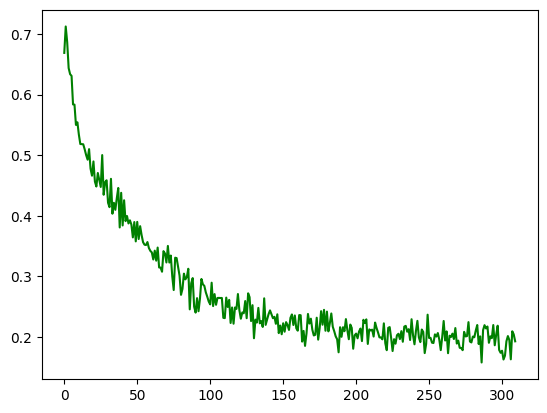

In [27]:
import matplotlib.pyplot as plt

plt.plot(loss_values[100:], 'g')
plt.show()